In [ ]:
%pwd

'/content'

In [ ]:
%cd '/content/drive/MyDrive/2022_10_21/독일 교통표지판'

/content/drive/MyDrive/2022_10_21/독일 교통표지판


In [ ]:
%pwd

'/content/drive/MyDrive/2022_10_21/독일 교통표지판'

In [ ]:
!unzip -qq "/content/drive/MyDrive/2022_10_21/독일 교통표지판/독일교통표지판.zip"

In [ ]:
# !unzip -qq "/content/drive/MyDrive/2022_10_21/10_[이미지이지AI]해양쓰레기분류.zip"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 32   # 한셋트에 몇개의 자료를 넣을것인가? 기본 32로 많이하나 조정해도됨. 숫자를 적게할수록 처리속도가 느려짐
img_height = 180
img_width = 180

# data_dir='/content/drive/MyDrive/한경IT_5차/data/flower_photos/'
train_dir = '/content/drive/MyDrive/2022_10_21/독일 교통표지판/Train/'
# test_dir = '/content/drive/MyDrive/2022_10_21/독일 교통표지판/Test/'

# 전체 3670개의 이미지자료에서 80%의 2936개를 트레이닝(훈련)자료로 세팅함
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,   # 3670*80%=2936, subset이 training여서 1-0.2임
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)     # 2936개의이미지를 32개씩 세트해서 묶음. 즉 92개세트가 나옴 (92세트*32)

# 전체 3670개의 이미지자료에서 20%의 734개를 테스트데이터로 세팅함
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# train_ds에 할당된 data_dir 폴더명
class_names = train_ds.class_names
print(class_names)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [ ]:
print(len(class_names))

43


In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

base_model = VGG16(input_shape=(180,180,3),
                   include_top=False,
                   weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(43,activation='softmax')

inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # y값이 원핫인코딩이 안되어 있어서임
              metrics=['accuracy'])


# 모델 최적화를 위한 설정 구간입니다.

modelpath="/content/drive/MyDrive/2022_10_21/독일 교통표지판/독일 교통표지판.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, 
                               monitor='val_loss',       # val_loss값을 기준으로
                               verbose=1,                # 실행결과를 화면에 출력함. verbose=0하면 실행결과가 화면에 나타나지않음
                               save_best_only=True)  # 가장좋은(즉 loss숫자가 가장 낮은) 모델을 저장함

# early_stopping_callback = EarlyStopping(monitor='val_loss')
#                                         ,patience=5) # 실행하다가 5번이상 더 좋은 결과가 없으면 중단

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpointer]
)

Epoch 1/100
980/981 [============================>.] - ETA: 0s - loss: 2.6302 - accuracy: 0.2956
Epoch 1: val_loss improved from inf to 2.19137, saving model to /content/drive/MyDrive/2022_10_21/독일 교통표지판/독일 교통표지판.hdf5
981/981 [==============================] - 173s 174ms/step - loss: 2.6302 - accuracy: 0.2956 - val_loss: 2.1914 - val_accuracy: 0.4167
Epoch 2/100
981/981 [==============================] - ETA: 0s - loss: 2.0781 - accuracy: 0.4290
Epoch 2: val_loss improved from 2.19137 to 1.90931, saving model to /content/drive/MyDrive/2022_10_21/독일 교통표지판/독일 교통표지판.hdf5
981/981 [==============================] - 167s 170ms/step - loss: 2.0781 - accuracy: 0.4290 - val_loss: 1.9093 - val_accuracy: 0.4928
Epoch 3/100
980/981 [============================>.] - ETA: 0s - loss: 1.8805 - accuracy: 0.4783
Epoch 3: val_loss improved from 1.90931 to 1.75178, saving model to /content/drive/MyDrive/2022_10_21/독일 교통표지판/독일 교통표지판.hdf5
981/981 [==========================

KeyboardInterrupt: ignored

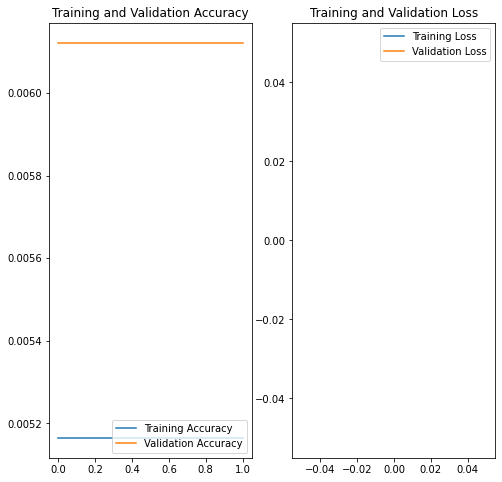

In [ ]:
## 차트작성함
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.history

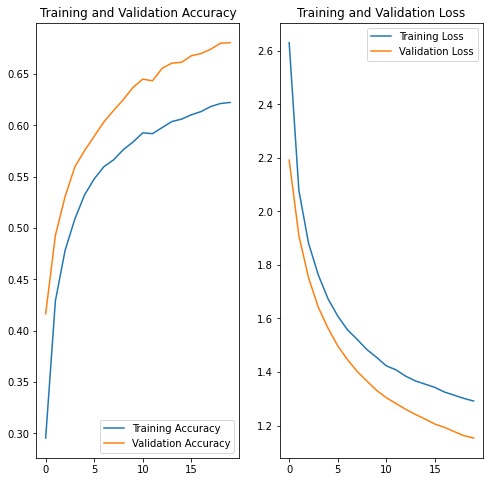

In [ ]:
## 차트작성함
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import random

In [ ]:
img = Image.open('./Test/00000.png')
img = img.resize((180,180))
img = np.array(img)
img = img.reshape((1,180,180,3))
pre = model.predict(img)
print(pre)
print(pre.argmax())

1/1 [==============================] - 0s 26ms/step
[[1.4477609e-05 2.0545506e-06 1.2518739e-02 1.4191235e-09 1.5740274e-12
  2.3581766e-12 6.4580802e-10 2.7180527e-06 9.0121126e-01 2.0968151e-05
  6.2614758e-10 9.5903419e-09 7.3009564e-06 3.8889586e-10 1.0825486e-09
  7.3778317e-11 5.9901806e-10 2.3693677e-11 9.6165487e-10 6.1920781e-11
  4.3255818e-10 5.2899725e-08 5.4143096e-10 1.5403084e-06 7.8737891e-11
  5.4328525e-12 1.5070698e-08 6.3850152e-08 1.4997088e-08 2.3699260e-09
  1.2869867e-08 7.6281303e-08 4.5665931e-07 1.2005117e-07 4.4855018e-04
  8.7449600e-08 2.7951466e-05 6.3388234e-07 1.9927577e-06 1.8830773e-08
  1.6395357e-03 6.1041489e-04 8.3490819e-02]]
8


In [ ]:
label = os.listdir('./Train')
print(label)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


1/1 [==============================] - 0s 25ms/step
[[1.4477609e-05 2.0545506e-06 1.2518739e-02 1.4191235e-09 1.5740274e-12
  2.3581766e-12 6.4580802e-10 2.7180527e-06 9.0121126e-01 2.0968151e-05
  6.2614758e-10 9.5903419e-09 7.3009564e-06 3.8889586e-10 1.0825486e-09
  7.3778317e-11 5.9901806e-10 2.3693677e-11 9.6165487e-10 6.1920781e-11
  4.3255818e-10 5.2899725e-08 5.4143096e-10 1.5403084e-06 7.8737891e-11
  5.4328525e-12 1.5070698e-08 6.3850152e-08 1.4997088e-08 2.3699260e-09
  1.2869867e-08 7.6281303e-08 4.5665931e-07 1.2005117e-07 4.4855018e-04
  8.7449600e-08 2.7951466e-05 6.3388234e-07 1.9927577e-06 1.8830773e-08
  1.6395357e-03 6.1041489e-04 8.3490819e-02]]
8
16


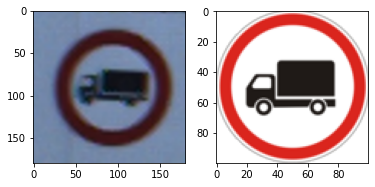

In [ ]:
img = Image.open('./Test/00000.png')
img = img.resize((180,180))
plt.subplot(1,2,1)
plt.imshow(img)
img = np.array(img)
img = img.reshape((1,180,180,3))
pre = model.predict(img)
print(pre)
print(pre.argmax())
print(label[pre.argmax()])

img_meta = Image.open(f'./Meta/{label[pre.argmax()]}.png')
plt.subplot(1,2,2)
plt.imshow(img_meta)
plt.show()

In [ ]:
df_test = pd.read_csv('./Test.csv')
df_test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [ ]:
test_pathes = df_test['Path'].values
test_pathes

array(['Test/00000.png', 'Test/00001.png', 'Test/00002.png', ...,
       'Test/12627.png', 'Test/12628.png', 'Test/12629.png'], dtype=object)

In [ ]:
test_classIds = df_test['ClassId'].values
test_classIds

array([16,  1, 38, ...,  6,  7, 10])

1/1 [==============================] - 0s 19ms/step
16 16
<class 'str'> <class 'numpy.int64'>


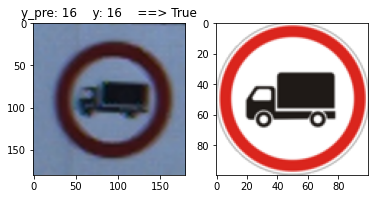

In [ ]:
for i,test_path in enumerate(test_pathes):
  img = Image.open(f'./{test_path}')
  img = img.resize((180,180))
  img_np = np.array(img)
  img_np = img_np.reshape((1,180,180,3))
  pre = model.predict(img_np)
  # print(pre)
  # print(pre.argmax())
  # print(label[pre.argmax()])
  pre_num = label[pre.argmax()]

  img_meta = Image.open(f'./Meta/{label[pre.argmax()]}.png')

  print(pre_num, test_classIds[i])
  print(type(pre_num), type(test_classIds[i]))
  if pre_num == str(test_classIds[i]):
    res = 'True'
  else:
    res = 'False'

  plt.subplot(1,2,1)
  plt.title( 'y_pre: ' + str(pre_num) + '    y: ' + str(test_classIds[i]) + '    ==> ' + res)
  plt.imshow(img)
  plt.subplot(1,2,2)
  plt.imshow(img_meta)
  plt.show()
  break

In [ ]:
ran_nums = random.sample(list(df_test.index.values), 5)
ran_nums

[6703, 11912, 187, 7193, 4947]

In [ ]:
tmp = df_test['Path'][ran_nums]
list(tmp.values)

['Test/06703.png',
 'Test/11912.png',
 'Test/00187.png',
 'Test/07193.png',
 'Test/04947.png']

In [ ]:
tmp = df_test['ClassId'][ran_nums]
list(tmp.values)

[36, 17, 8, 1, 9]

In [ ]:
df_test.loc[[6703, 11912, 187, 7193, 4947],:]

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
6703,48,52,5,6,43,47,3,Test/06703.png
11912,74,70,6,7,68,64,26,Test/11912.png
187,34,34,5,6,28,29,1,Test/00187.png
7193,32,33,5,5,27,27,12,Test/07193.png
4947,41,40,5,5,36,35,8,Test/04947.png


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
9021,42,42,6,5,37,37,2,Test/09021.png
12008,35,31,5,5,30,26,22,Test/12008.png
6549,63,69,6,6,58,63,38,Test/06549.png
4535,54,52,6,6,49,47,18,Test/04535.png
5043,97,87,9,7,89,80,27,Test/05043.png


1/1 [==============================] - 0s 18ms/step


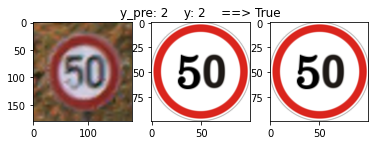

1/1 [==============================] - 0s 23ms/step


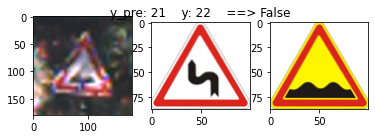

1/1 [==============================] - 0s 18ms/step


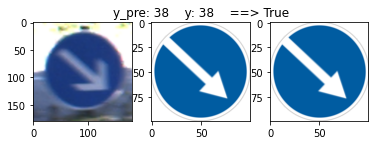

1/1 [==============================] - 0s 25ms/step


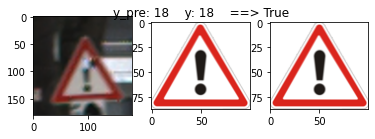

1/1 [==============================] - 0s 18ms/step


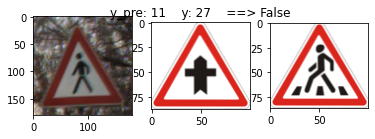

In [ ]:
ran_nums = random.sample(list(df_test.index.values), 5)
files = df_test['Path'][ran_nums]
files = list(files.values)
labels = df_test['ClassId'][ran_nums]
labels = list(labels)
display(df_test.loc[ran_nums,:])

for i,file in enumerate(files):
  img = Image.open(f'./{file}')
  img = img.resize((180,180))
  img_np = np.array(img)
  img_np = img_np.reshape((1,180,180,3))
  pre = model.predict(img_np)
  # print(pre)
  # print(pre.argmax())
  # print(label[pre.argmax()])
  pre_num = label[pre.argmax()]

  img_pre = Image.open(f'./Meta/{pre_num}.png')
  img_y = Image.open(f'./Meta/{labels[i]}.png')

  # print(pre_num, test_classIds[i])
  # print(type(pre_num), type(test_classIds[i]))
  if pre_num == str(labels[i]):
    res = 'True'
  else:
    res = 'False'

  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.subplot(1,3,2)
  plt.title( 'y_pre: ' + str(pre_num) + '    y: ' + str(labels[i]) + '    ==> ' + res)
  plt.imshow(img_pre)
  plt.subplot(1,3,3)
  plt.imshow(img_y)
  plt.show()